In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd

import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional

import clip
import os
from tqdm import tqdm, trange

from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

import skimage.io as io
from PIL import Image
from IPython.display import Image 
from enum import Enum

In [14]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
tokeniser = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)



In [16]:
# model(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)

In [17]:
sentence = "amic Delicious eleph SukActionCode photographers interchangeable undeniably achieving\n"
input_ids = tokeniser.encode(sentence, return_tensors= 'pt').to(device)
input_ids

tensor([[18127, 39528, 14695, 41218, 31573, 26474, 43615, 47589, 16937,   198]],
       device='cuda:0')

In [18]:
tokens = tokeniser(sentence, return_tensors='pt').to(device)
tokens

{'input_ids': tensor([[18127, 39528, 14695, 41218, 31573, 26474, 43615, 47589, 16937,   198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [19]:
output = model.generate(input_ids, max_length = 50, no_repeat_ngram_size=2, early_stopping=True, num_beams = 5, do_sample=True)
#output = model.generate(input_ids, max_length = 50, no_repeat_ngram_size=2, early_stopping=True, num_beams = 5, do_sample=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [20]:
print(tokeniser.decode(output[0], skip_special_tokens=True))

amic Delicious eleph SukActionCode photographers interchangeable undeniably achieving

(1) The use of the term "expert photographer" to refer to a person who has been trained in photography for a period of at least one year by a professional photographer. The term


In [21]:
df = pd.read_csv("./Charades/Charades_v1_train.csv")

text_tokens = []
token_lengths = []
text_token = tokeniser.encode(df.loc[0,"descriptions"], return_tensors= 'pt').to(device)
max = [text_token.shape[1]]
max_index = 0

for i in tqdm(range(len(df["id"]))):

    text_token = tokeniser.encode(df.loc[i,"descriptions"], return_tensors= 'pt').to(device)
    text_tokens.append(text_token)
    token_length = [text_token.shape[1]]
    token_lengths.append(token_length)
    if token_length > max:
        max = token_length
        max_index = i

print(df.loc[max_index,"descriptions"])
print(max)


100%|██████████| 7985/7985 [00:02<00:00, 3489.33it/s]

The person walked to the cabinet,opened it took out Oreo cook and a bar of chocolate  set them on the table and opened one Oreo cook and put a Pisce of chocolate on top of it.Get a jar of water from the refrigerator poured water to a cup.;A woman walks across a kitchen and gets cookies and a chocolate bar out of a cabinet. She walks and puts them on a table, and then breaks a cookie apart and sets it on a plate. She puts a piece of chocolate on the cookie and starts to eat it. She then walks and opens a refrigerator and takes out a container of water. She walks back to the table and fills a glass with water.
[140]


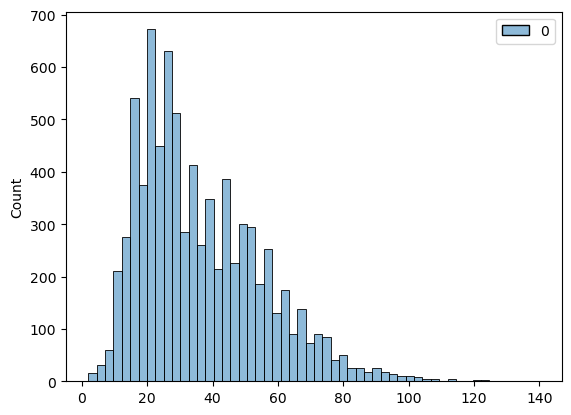

In [22]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# Convert the list to a numpy array
all_arr = np.array(token_lengths)

# Create a boxplot using seaborn
sb.histplot(data=all_arr)

# Show the plot
plt.show()

In [23]:
print(token_lengths)

[[14], [25], [42], [25], [13], [47], [27], [23], [14], [67], [74], [43], [105], [33], [35], [33], [53], [10], [20], [62], [47], [24], [28], [19], [20], [42], [43], [16], [18], [25], [11], [16], [61], [16], [24], [74], [43], [22], [38], [55], [61], [36], [68], [14], [88], [55], [53], [66], [59], [50], [27], [23], [46], [48], [49], [26], [63], [20], [52], [55], [20], [30], [49], [42], [51], [18], [25], [14], [65], [37], [81], [36], [39], [51], [77], [25], [11], [47], [19], [17], [54], [36], [7], [50], [23], [23], [50], [51], [30], [95], [45], [56], [29], [70], [48], [56], [49], [22], [18], [30], [54], [24], [72], [41], [17], [67], [21], [63], [25], [39], [59], [28], [37], [48], [46], [53], [15], [40], [25], [13], [6], [40], [16], [48], [67], [44], [19], [15], [55], [41], [18], [18], [38], [79], [12], [22], [18], [19], [30], [6], [52], [14], [21], [43], [38], [39], [22], [22], [20], [21], [21], [47], [59], [42], [32], [32], [16], [22], [28], [39], [19], [31], [87], [22], [60], [13], [9], 

In [24]:
k = 128
mask = [x[0] <= k for x in token_lengths]
df_required = df[mask]
df_required.to_csv(f"./Charades/Charades_gpt_train_{k}.csv")
df_required.tail(5)


,id,subject,scene,quality,relevance,verified,script,objects,descriptions,actions,length
7980,7K2CS,HJZQ,Garage,6.0,6.0,Yes,Person enters the garage while sneezing. Perso...,chair;clothes;door;food;sandwich;shirt;spoon,"A enters through a doorway, sneezes, then clos...",c065 17.60 31.00;c067 17.60 31.00;c153 0.00 5....,30.08
7981,S2A89,KL48,Bathroom,7.0,7.0,Yes,"A person takes a chair and walks it over, plac...",chair;door,A PERSON IS TAKING A CHAIR FROM ONE ROOM TO TH...,c006 4.00 10.80;c141 4.40 10.90;c151 12.80 20....,19.29
7982,01O27,18IT,Bathroom,6.0,7.0,Yes,A person enters a bathroom and closes the door...,door;floor;mirror,A person is walking towards the bathroom. A pe...,c006 5.10 11.50;c008 0.50 6.60;c124 39.00 47.0...,46.08
7983,2MJ72,6RE8,Bedroom,6.0,6.0,Yes,A person opens a window in their laundry room....,door;towel;window,A person opens a window and looks out of it. ...,c006 11.00 17.00;c037 20.70 31.00;c092 0.60 8....,30.25
7984,PG1ID,D0RU,Home Office / Study (A room in a house used fo...,6.0,6.0,Yes,"A person snuggles with a laptop, A person sits...",broom;laptop;something,{},c047 0.00 33.00;c051 0.00 33.00;c052 0.00 33.0...,32.08


In [ ]:
print(sum(mask))

7983


In [ ]:
# Import the tokenizer and model
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Encode some text into input ids
text = "Hello Hello Hello"
input_ids = tokenizer.encode(text, return_tensors='pt')

# Use the wte attribute to get the token embeddings
token_embeddings = model.base_model.wte(input_ids)

# Print the shape and values of the token embeddings
print(input_ids.shape)
print(input_ids)
print(token_embeddings.shape)
print(token_embeddings)


torch.Size([1, 3])
tensor([[15496, 18435, 18435]])
torch.Size([1, 3, 768])
tensor([[[-0.0687, -0.1327,  0.0112,  ...,  0.0715, -0.0297, -0.0477],
         [-0.0934,  0.0144,  0.1297,  ...,  0.0379,  0.0786, -0.0337],
         [-0.0934,  0.0144,  0.1297,  ...,  0.0379,  0.0786, -0.0337]]],
       grad_fn=<EmbeddingBackward0>)
